<a href="https://colab.research.google.com/github/kanri3/deep_learning_day1_day2/blob/main/2_3_1_overfiting_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')
# sys.path.append('/content/drive/My Drive/DNN_code/lesson_2')

In [ ]:
import numpy as np
from collections import OrderedDict
from common import layers, optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from common.multi_layer_net import MultiLayerNet
# from multi_layer_net import MultiLayerNet
# from common import optimizer
import copy

(x_train, d_train), (x_test, d_test) = load_mnist(normalize = True)

print("データ読み込み完了")

# 過学習を再現するために、学習データを削減
# x_train = x_train[:200]
# d_train = d_train[:200]
x_train = x_train[:300]
d_train = d_train[:300]

network_init = MultiLayerNet(input_size=784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10)

optimizer_SDG_init = optimizer.SGD(learning_rate = 0.01)

iters_num = 500
# iters_num = 1000
train_size = x_train.shape[0]
# batch_size = 10
batch_size = 100
# plot_interval=50
plot_interval=100

# グラフ
def draw_graph(title, legend_position):
# def draw_graph(accuracies_train, accuracies_test, legend_position):
    lists = range(0, iters_num + 1, plot_interval)
    # lists = range(0, iters_num, plot_interval)
    # print("lists, accuracies_train :", lists, accuracies_train)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc = legend_position)
    # plt.legend(loc="lower right")
    plt.title(title)
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

データ読み込み完了


# overfiting

Generation: 1. 正答率(トレーニング) = 0.07667
                : 1. 正答率(テスト) = 0.08870
Generation: 100. 正答率(トレーニング) = 0.84667
                : 100. 正答率(テスト) = 0.62980
Generation: 200. 正答率(トレーニング) = 0.96000
                : 200. 正答率(テスト) = 0.73550
Generation: 300. 正答率(トレーニング) = 0.99000
                : 300. 正答率(テスト) = 0.75480
Generation: 400. 正答率(トレーニング) = 1.00000
                : 400. 正答率(テスト) = 0.76010
Generation: 500. 正答率(トレーニング) = 1.00000
                : 500. 正答率(テスト) = 0.76210


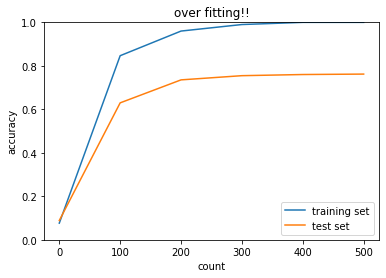

In [ ]:
train_loss_list = []
accuracies_train = []
accuracies_test = []
optimizer_SDG = copy.deepcopy(optimizer_SDG_init)
network = copy.deepcopy(network_init)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer_SDG.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0 or i == 0:
    # if (i + 1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        # s_format = format(accr_train, '.5f')
        print('Generation: ' + str(i + 1) + '. 正答率(トレーニング) = ' + str(format(accr_train, '.5f')))
        # print('Generation: ' + str(i + 1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i + 1) + '. 正答率(テスト) = ' + str(format(accr_test, '.5f')))

# グラフの表示
draw_graph("over fitting!!", "lower right")

## weight decay
### L2

Generation: 1. 正答率(トレーニング) = 0.08333
                : 1. 正答率(テスト) = 0.08920
Generation: 100. 正答率(トレーニング) = 0.66667
                : 100. 正答率(テスト) = 0.50770
Generation: 200. 正答率(トレーニング) = 0.85000
                : 200. 正答率(テスト) = 0.68950
Generation: 300. 正答率(トレーニング) = 0.88000
                : 300. 正答率(テスト) = 0.70690
Generation: 400. 正答率(トレーニング) = 0.92000
                : 400. 正答率(テスト) = 0.75180
Generation: 500. 正答率(トレーニング) = 0.90667
                : 500. 正答率(テスト) = 0.74990


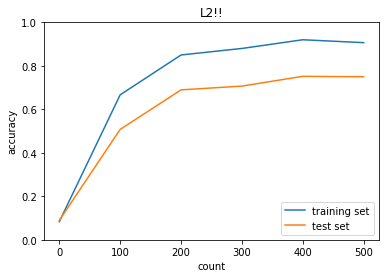

In [ ]:
train_loss_list = []
accuracies_train = []
accuracies_test = []
network = copy.deepcopy(network_init)
learning_rate = 0.01
hidden_layer_num = network.hidden_layer_num

# 正則化強度設定 ハイパーパラメータ ===========================
weight_decay_lambda = 0.1
# ============================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num + 1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * network.params['W' + str(idx)]
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += 0.5 * weight_decay_lambda * np.sqrt(np.sum(network.params['W' + str(idx)] ** 2))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0 or i == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(format(accr_train, '.5f')))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(format(accr_test, '.5f')))               

# グラフの表示
draw_graph("L2!!", "lower right")

### L1

Generation: 1. 正答率(トレーニング) = 0.17667
                : 1. 正答率(テスト) = 0.14950
Generation: 100. 正答率(トレーニング) = 0.70333
                : 100. 正答率(テスト) = 0.49930
Generation: 200. 正答率(トレーニング) = 0.64000
                : 200. 正答率(テスト) = 0.52050
Generation: 300. 正答率(トレーニング) = 0.72000
                : 300. 正答率(テスト) = 0.56210
Generation: 400. 正答率(トレーニング) = 0.77000
                : 400. 正答率(テスト) = 0.61060
Generation: 500. 正答率(トレーニング) = 0.78000
                : 500. 正答率(テスト) = 0.61590


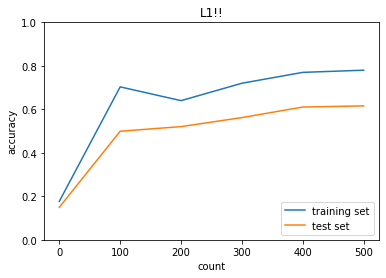

In [ ]:
network = copy.deepcopy(network_init)
train_loss_list = []
accuracies_train = []
accuracies_test = []
learning_rate=0.1
hidden_layer_num = network.hidden_layer_num
# plot_interval=10

# 正則化強度設定 ハイパーパラメータ ===========================
weight_decay_lambda = 0.007
# ============================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num + 1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0 or i == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(format(accr_train, '.5f')))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(format(accr_test, '.5f')))               

# グラフの表示
draw_graph("L1!!", "lower right")

## Dropout

In [ ]:
# class Dropout:
#     def __init__(self, dropout_ratio=0.5):
#         self.dropout_ratio = dropout_ratio
#         self.mask = None

#     def forward(self, x, train_flg=True):
#         if train_flg:
#             self.mask = np.random.rand(*x.shape) > self.dropout_ratio
#             return x * self.mask
#         else:
#             return x * (1.0 - self.dropout_ratio)

#     def backward(self, dout):
#         return dout * self.mask

Generation: 1. 正答率(トレーニング) = 0.12333
                : 1. 正答率(テスト) = 0.12300
Generation: 100. 正答率(トレーニング) = 0.52333
                : 100. 正答率(テスト) = 0.38150
Generation: 200. 正答率(トレーニング) = 0.75000
                : 200. 正答率(テスト) = 0.57760
Generation: 300. 正答率(トレーニング) = 0.82667
                : 300. 正答率(テスト) = 0.66460
Generation: 400. 正答率(トレーニング) = 0.91000
                : 400. 正答率(テスト) = 0.70290
Generation: 500. 正答率(トレーニング) = 0.94667
                : 500. 正答率(テスト) = 0.73130


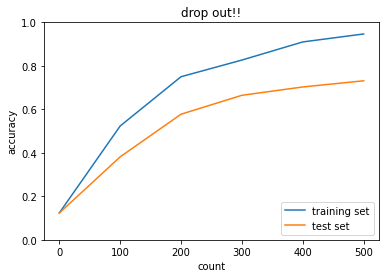

In [ ]:
from common import optimizer

# ドロップアウト設定 ======================================
use_dropout = True
# dropout_ratio = 0.3
dropout_ratio = 0.08
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda, use_dropout = use_dropout, dropout_ratio = dropout_ratio)
optimizer = optimizer.SGD(learning_rate=0.01)
# optimizer = optimizer.Momentum(learning_rate=0.01, momentum=0.9)
# optimizer = optimizer.AdaGrad(learning_rate=0.01)
# optimizer = optimizer.Adam()

train_loss_list = []
accuracies_train = []
accuracies_test = []
# plot_interval=10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)    
    
    if (i+1) % plot_interval == 0 or i==0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(format(accr_train,'.5f')))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(format(accr_test,'.5f')))        

# グラフの表示
draw_graph("drop out!!", "lower right")

## Dropout + L1

Generation: 1. 正答率(トレーニング) = 0.06667
                : 1. 正答率(テスト) = 0.05980
Generation: 100. 正答率(トレーニング) = 0.34333
                : 100. 正答率(テスト) = 0.24030
Generation: 200. 正答率(トレーニング) = 0.49333
                : 200. 正答率(テスト) = 0.38530
Generation: 300. 正答率(トレーニング) = 0.59333
                : 300. 正答率(テスト) = 0.46160
Generation: 400. 正答率(トレーニング) = 0.75667
                : 400. 正答率(テスト) = 0.59440
Generation: 500. 正答率(トレーニング) = 0.84000
                : 500. 正答率(テスト) = 0.68620


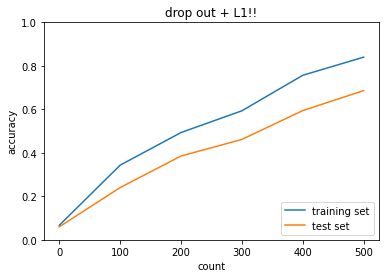

In [ ]:
# ドロップアウト設定 ======================================
use_dropout = True
dropout_ratio = 0.08
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        use_dropout = use_dropout, dropout_ratio = dropout_ratio)
learning_rate=0.01

train_loss_list = []
accuracies_train = []
accuracies_test = []
hidden_layer_num = network.hidden_layer_num
# plot_interval=10

# 正則化強度設定 ハイパーパラメータ ==========================
weight_decay_lambda=0.004
# =============================================================

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    grad = network.gradient(x_batch, d_batch)
    weight_decay = 0
    
    for idx in range(1, hidden_layer_num+1):
        grad['W' + str(idx)] = network.layers['Affine' + str(idx)].dW + weight_decay_lambda * np.sign(network.params['W' + str(idx)])
        grad['b' + str(idx)] = network.layers['Affine' + str(idx)].db
        network.params['W' + str(idx)] -= learning_rate * grad['W' + str(idx)]
        network.params['b' + str(idx)] -= learning_rate * grad['b' + str(idx)]        
        weight_decay += weight_decay_lambda * np.sum(np.abs(network.params['W' + str(idx)]))

    loss = network.loss(x_batch, d_batch) + weight_decay
    train_loss_list.append(loss)        
        
    if (i + 1) % plot_interval == 0 or i == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(format(accr_train,'.5f')))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(format(accr_test,'.5f')))               

# グラフの表示
draw_graph("drop out + L1!!", "lower right")